In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

In [3]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [4]:
EXP_DATASETS = ['high_school_biology', 'high_school_chemistry', 'high_school_computer_science', 'high_school_european_history', 'high_school_geography', 'high_school_government_and_politics', 'high_school_macroeconomics', 'high_school_mathematics', 'high_school_microeconomics', 'high_school_physics', 'high_school_psychology', 'high_school_statistics', 'high_school_us_history', 'high_school_world_history']


In [6]:
from collections import defaultdict
from datasets import load_dataset

lengths = defaultdict(list)

for dataset_id in EXP_DATASETS:
    print(f"Processing {dataset_id}")
    dataset = load_dataset("cais/mmlu", dataset_id)
    for example in dataset["test"]:
        lengths[dataset_id].append(len(example["question"]))

Processing high_school_biology
Processing high_school_chemistry
Processing high_school_computer_science
Processing high_school_european_history
Processing high_school_geography
Processing high_school_government_and_politics
Processing high_school_macroeconomics
Processing high_school_mathematics
Processing high_school_microeconomics
Processing high_school_physics
Processing high_school_psychology
Processing high_school_statistics
Processing high_school_us_history
Processing high_school_world_history


In [7]:
for k,v in lengths.items():
    print(k, sum(v)/len(v))

high_school_biology 147.65806451612903
high_school_chemistry 129.39408866995075
high_school_computer_science 223.41
high_school_european_history 1391.0
high_school_geography 86.03030303030303
high_school_government_and_politics 96.56994818652849
high_school_macroeconomics 96.42051282051283
high_school_mathematics 149.72962962962964
high_school_microeconomics 100.5546218487395
high_school_physics 201.91390728476821
high_school_psychology 137.77798165137614
high_school_statistics 266.5416666666667
high_school_us_history 1204.4411764705883
high_school_world_history 1341.9915611814347


In [5]:
import json

results = []

for root, dirs, files in os.walk("../data/calibration"):
    for file in files:
        if file.endswith(".json"):
            with open(os.path.join(root, file), "r") as f:
                rf = json.load(f)
                results.append(rf)

In [6]:
import pandas as pd

df = pd.DataFrame(results).drop_duplicates(["model", "dataset"])

for e in [
    "logN_normalized_entropy",
    "logD_normalized_entropy",
    "NlogD_normalized_entropy",
    "logNlogD_normalized_entropy",
    ]:
    df[f"last_{e}"] = df[e].apply(lambda x: x[-1])
    df["model"] = df["model"].apply(lambda x: x.split("/")[-1])

df = df[df["model"] != "Llama-2-13b-hf"]

print(df.shape)

(28, 16)


In [7]:
for e in [
    "logN_normalized_entropy",
    "logD_normalized_entropy",
    "NlogD_normalized_entropy",
    "logNlogD_normalized_entropy",
    ]:
    for i in range(len(df.iloc[0][e])):
        df[f"{e}_{i}"] = df[e].apply(lambda x: x[i]).copy()

/tmp/ipykernel_2600055/3980150154.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{e}_{i}"] = df[e].apply(lambda x: x[i]).copy()
/tmp/ipykernel_2600055/3980150154.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{e}_{i}"] = df[e].apply(lambda x: x[i]).copy()
/tmp/ipykernel_2600055/3980150154.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

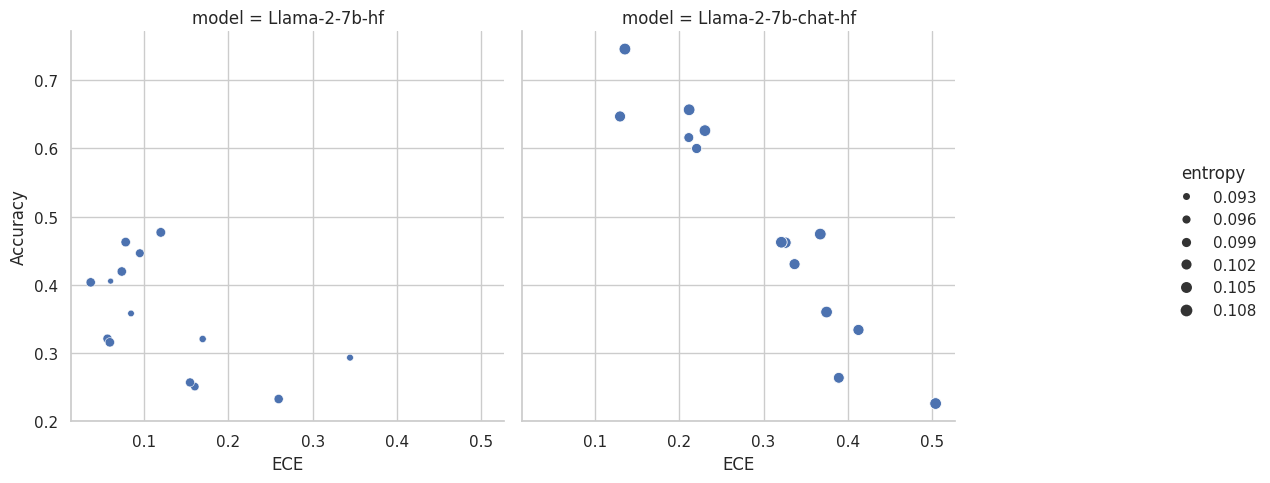

In [8]:
import seaborn as sns

sns.set_theme(style="whitegrid")

entropy = "logNlogD_normalized_entropy"
ax1 = sns.relplot(
    data=df,
    x="ece",
    y="acc",
    col="model",
    size=f"last_{entropy}",
    legend=True
)
ax1._legend.set_title('entropy')
ax1.set(xlabel='ECE', ylabel='Accuracy')

In [31]:
list(df["model"].unique())

['Llama-2-7b-hf', 'Llama-2-7b-chat-hf']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


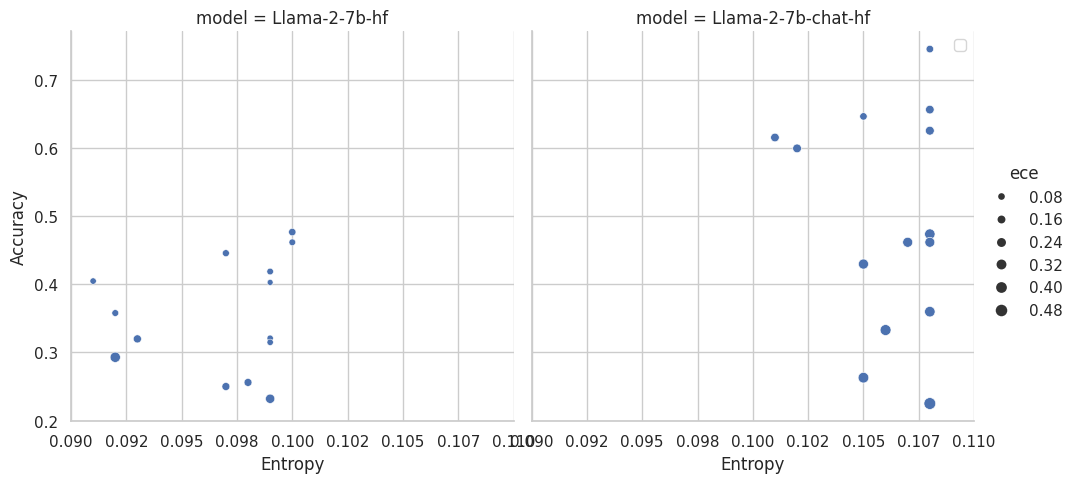

In [33]:
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

entropy = "logNlogD_normalized_entropy"

ax1 = sns.relplot(
    data=round(df, 3),
    x=f"last_{entropy}",
    y="acc",
    col="model",
    size="ece",
    legend=True
)

ax1._legend.set_title('ece')
ax1.set(xlabel='Entropy', ylabel='Accuracy')

ax1.set_xticklabels(['{:.3f}'.format(x) for x in ax1.axes[0][0].get_xticks()])

# # Add regression line
# for ax, model in zip(ax1.axes.flatten(), list(df["model"].unique())):
#     df_model = df[df["model"] == model]
#     sns.regplot(data=round(df_model, 3), x=f"last_{entropy}", y="acc", scatter=False, ax=ax)

plt.legend()


In [29]:
df_model

,labels,probs,gts,logN_normalized_entropy,logD_normalized_entropy,NlogD_normalized_entropy,logNlogD_normalized_entropy,model,dataset,acc,...,logNlogD_normalized_entropy_23,logNlogD_normalized_entropy_24,logNlogD_normalized_entropy_25,logNlogD_normalized_entropy_26,logNlogD_normalized_entropy_27,logNlogD_normalized_entropy_28,logNlogD_normalized_entropy_29,logNlogD_normalized_entropy_30,logNlogD_normalized_entropy_31,logNlogD_normalized_entropy_32


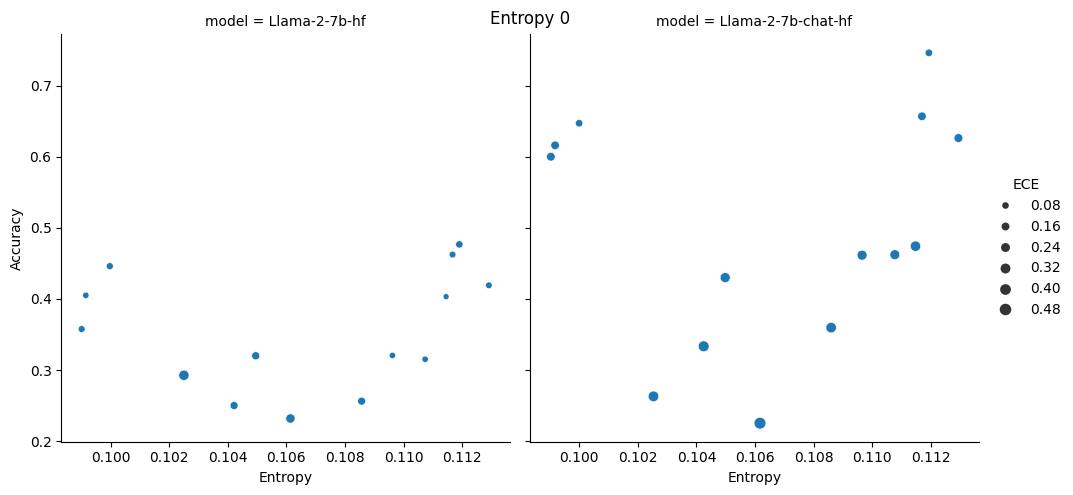

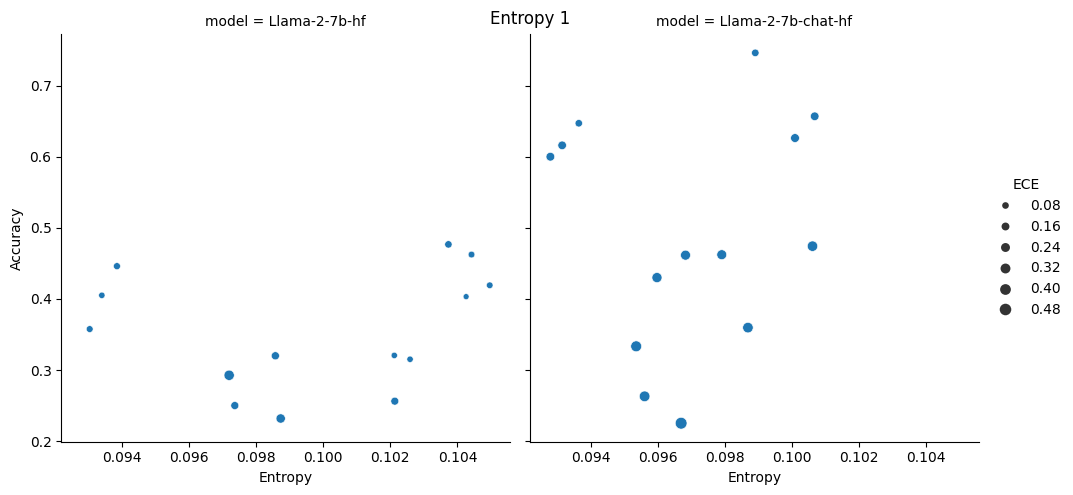

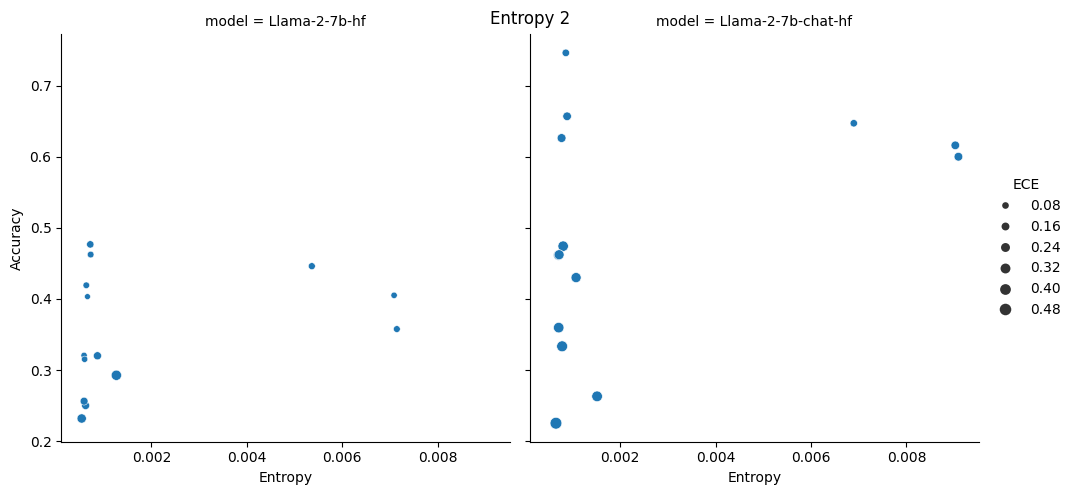

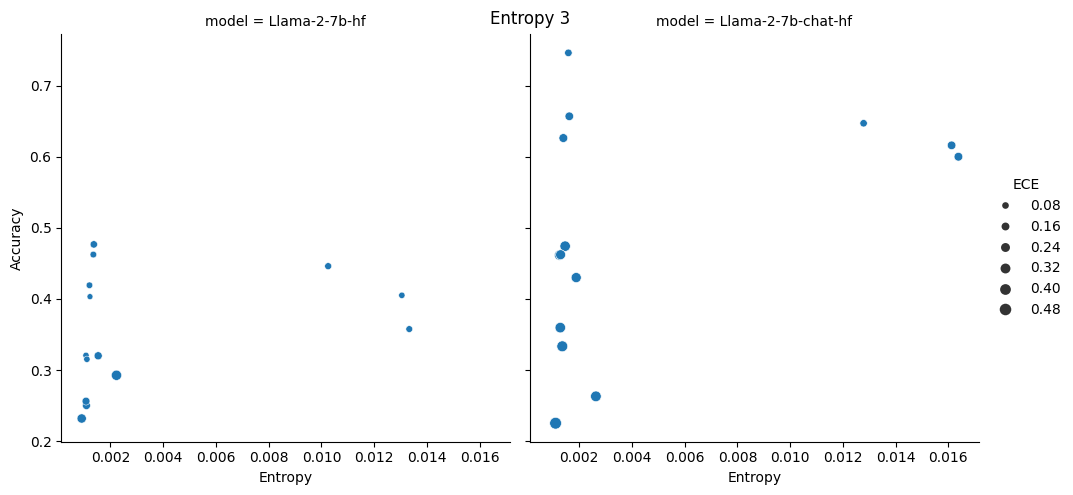

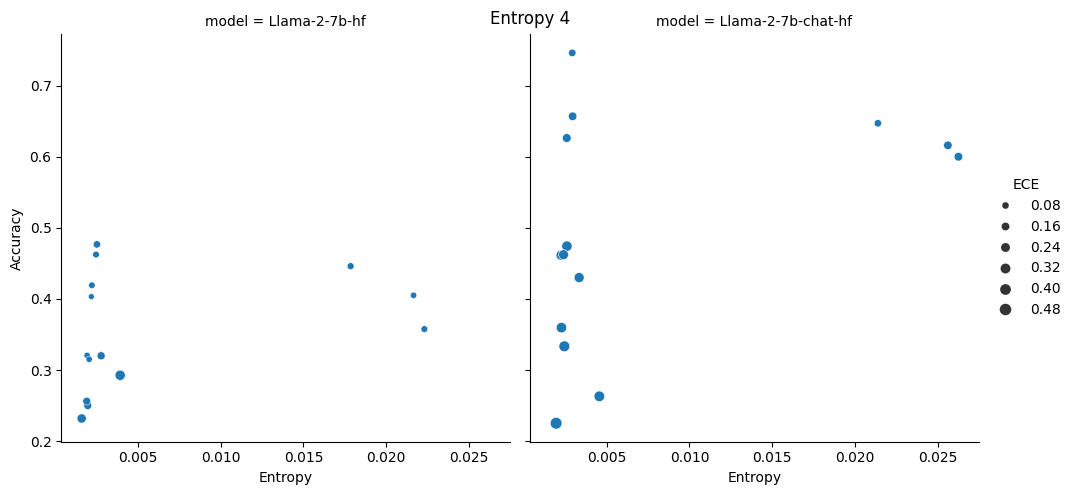

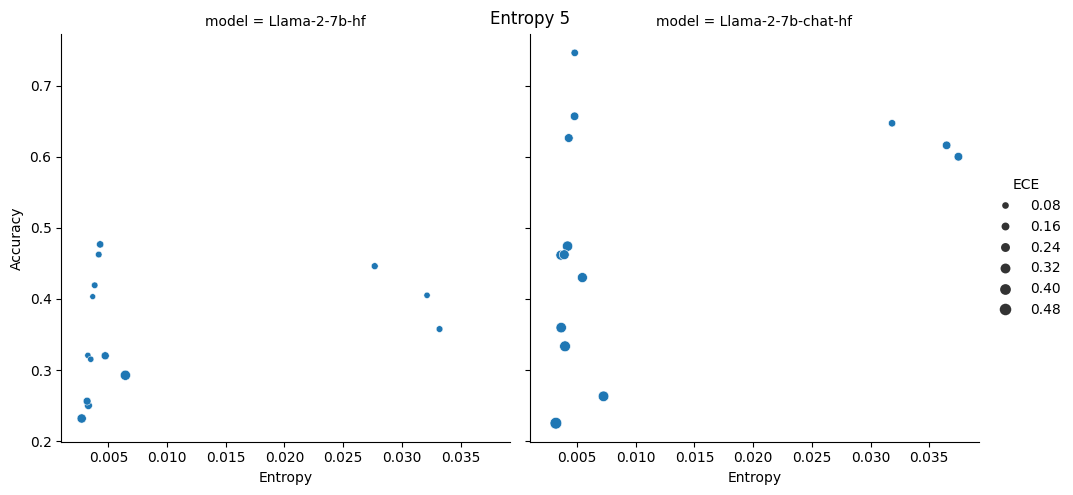

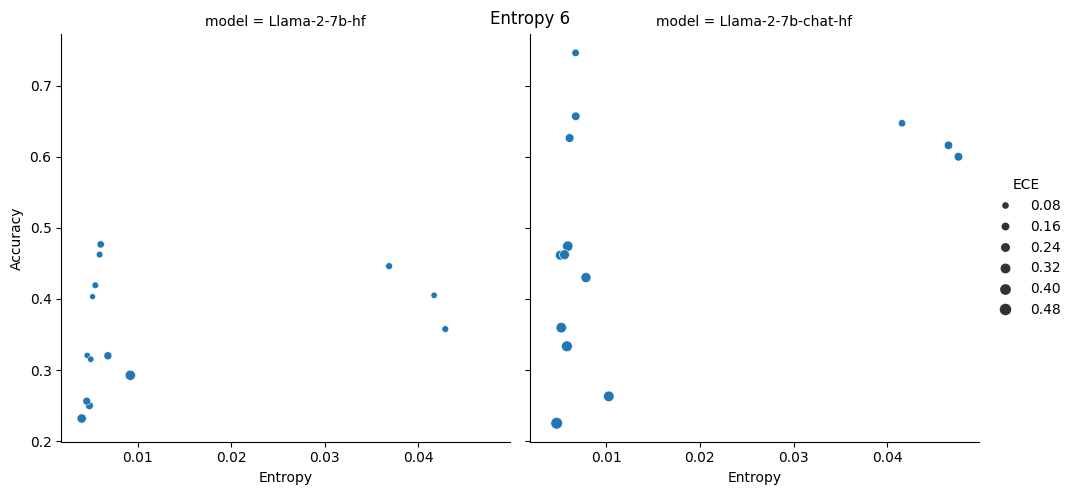

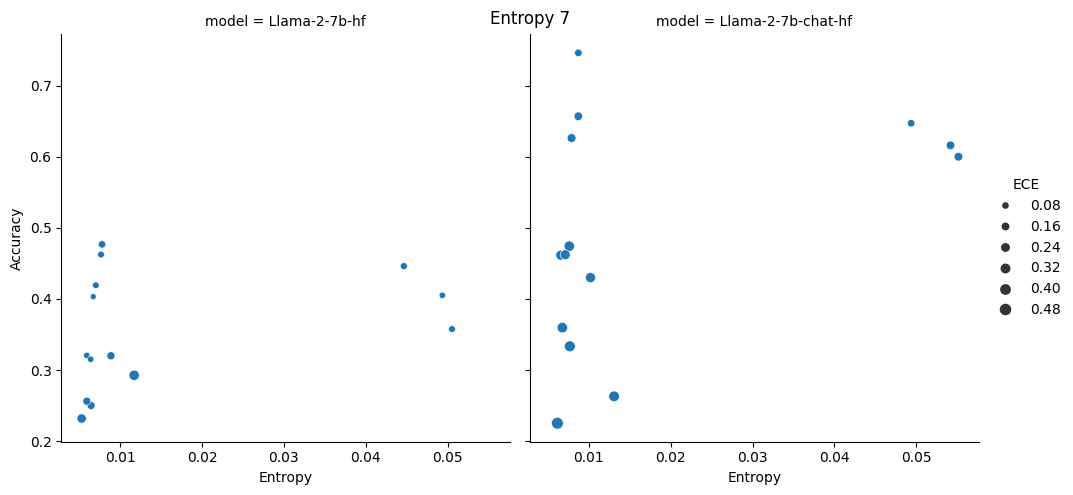

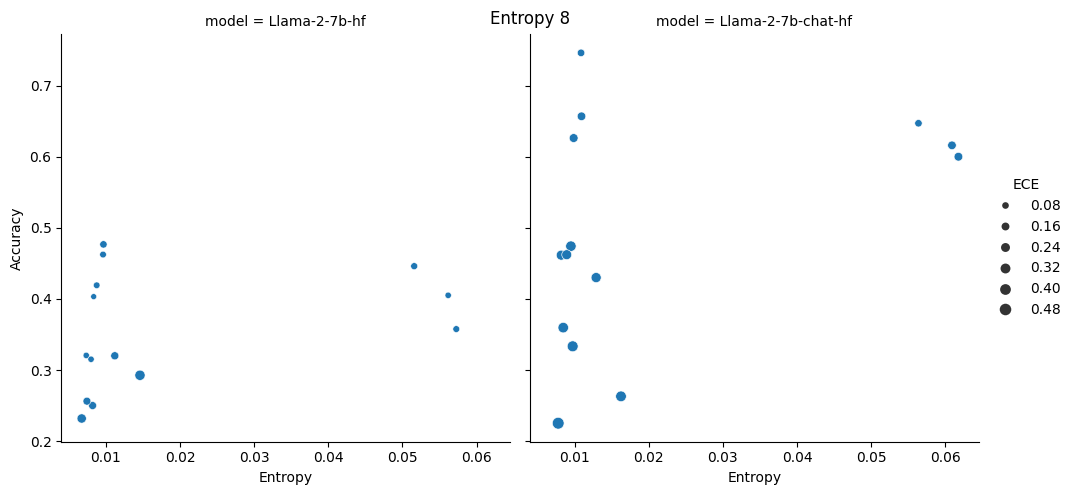

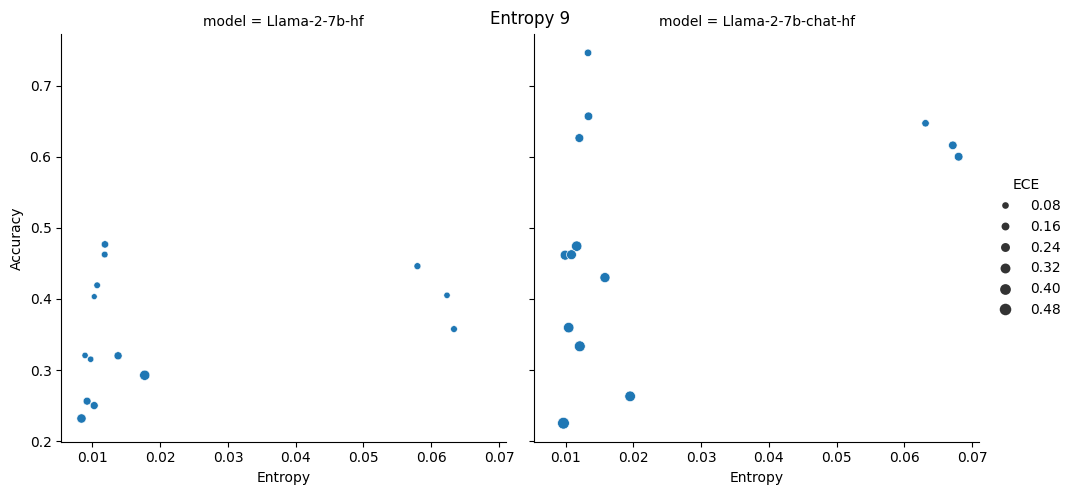

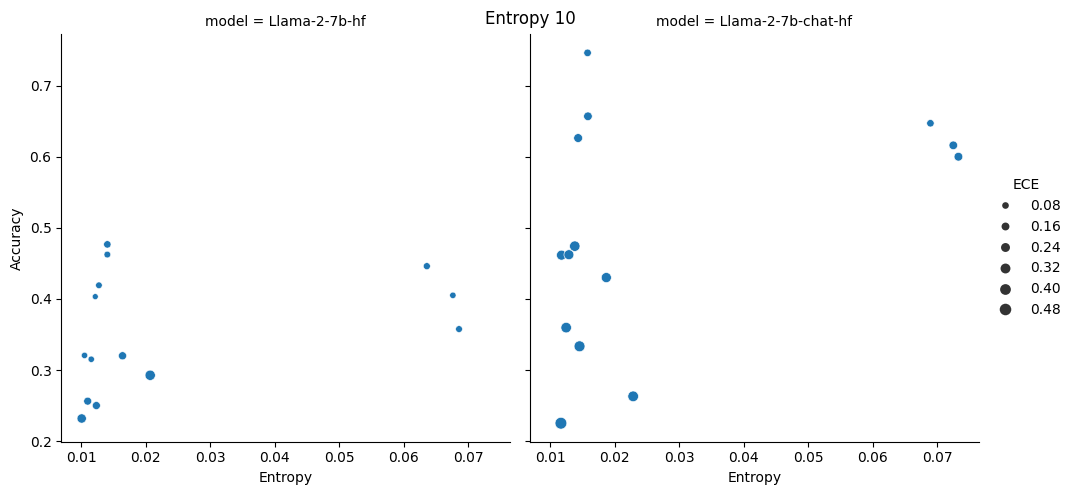

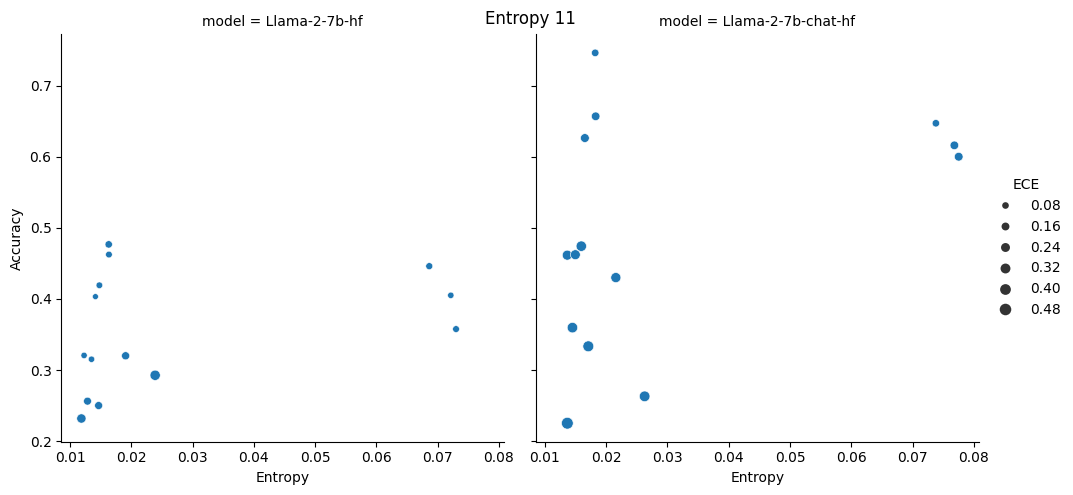

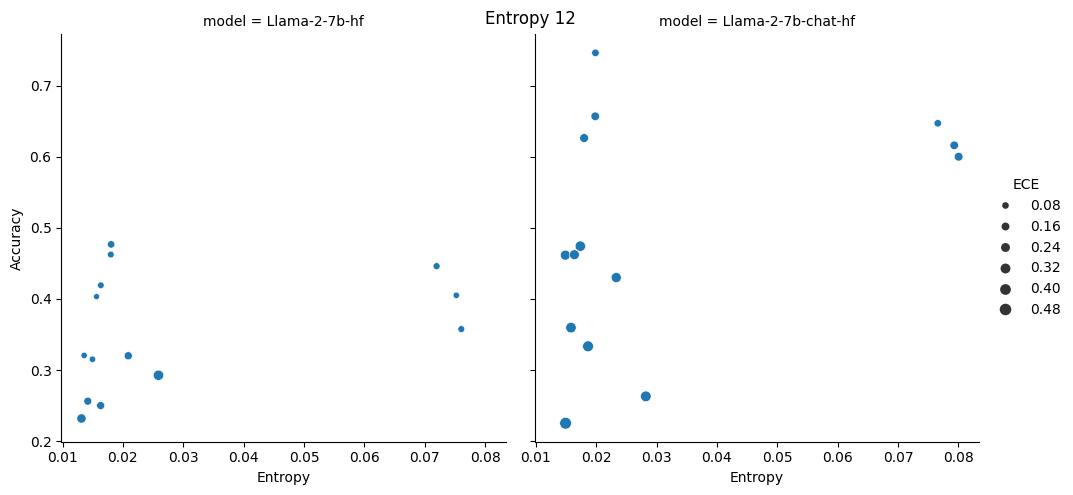

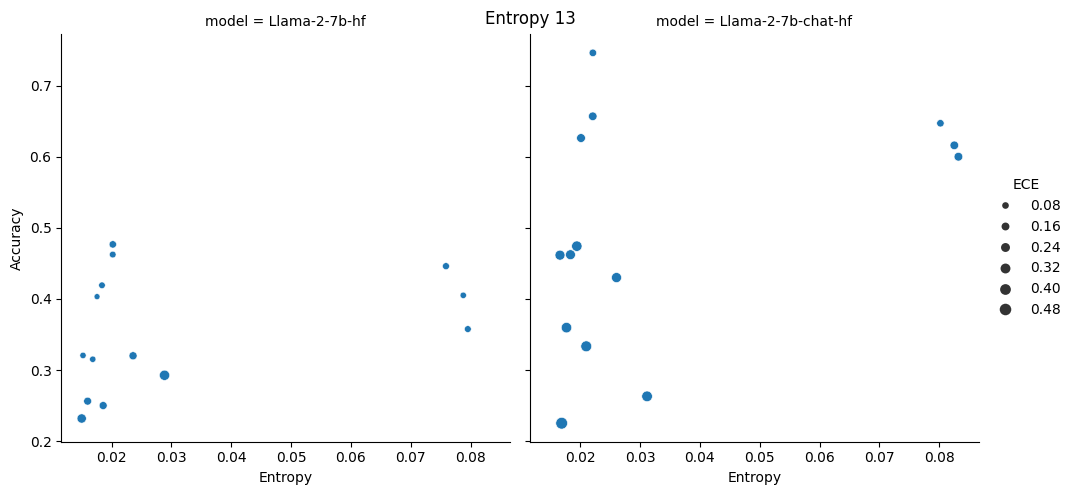

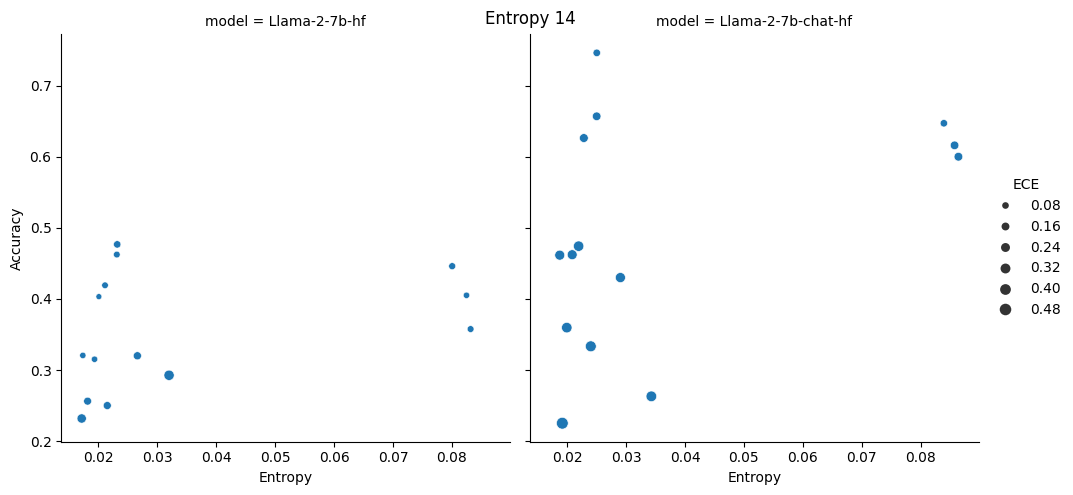

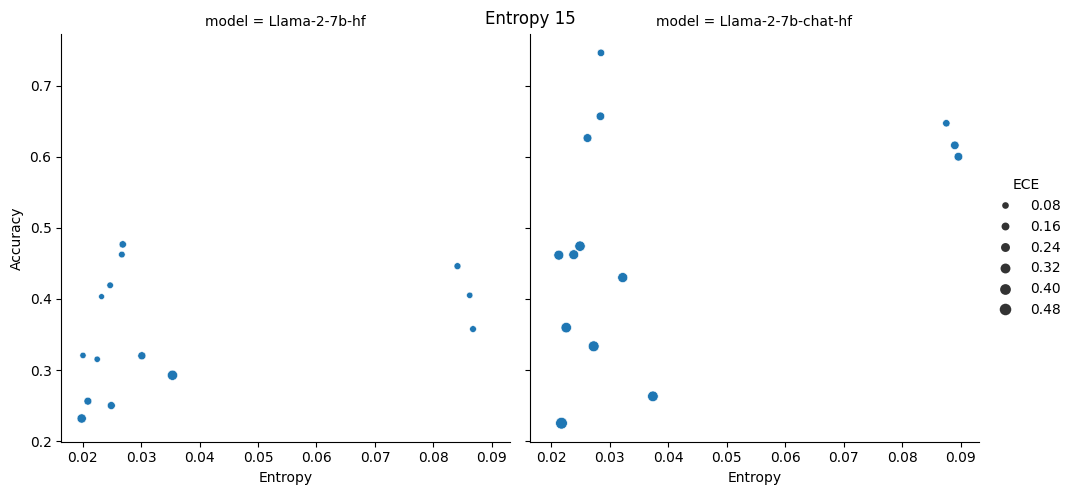

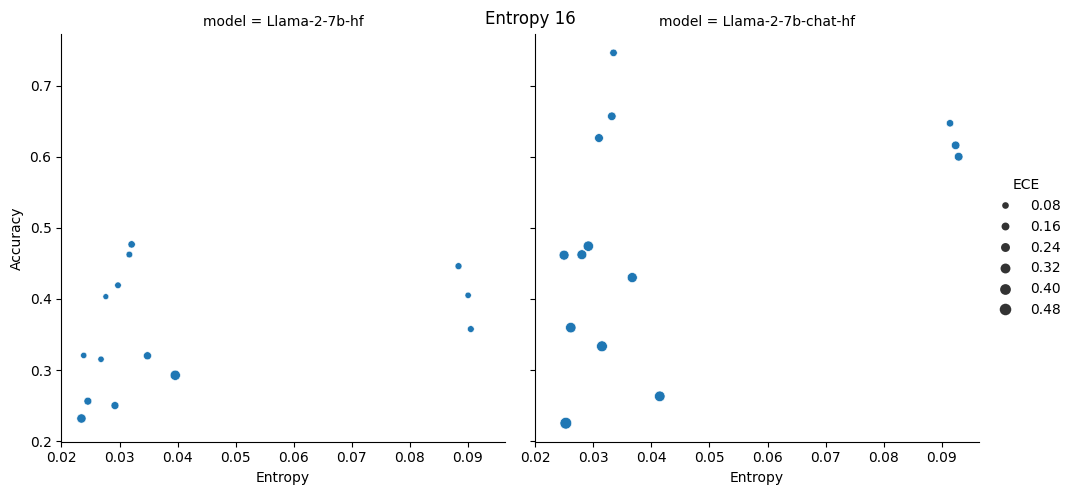

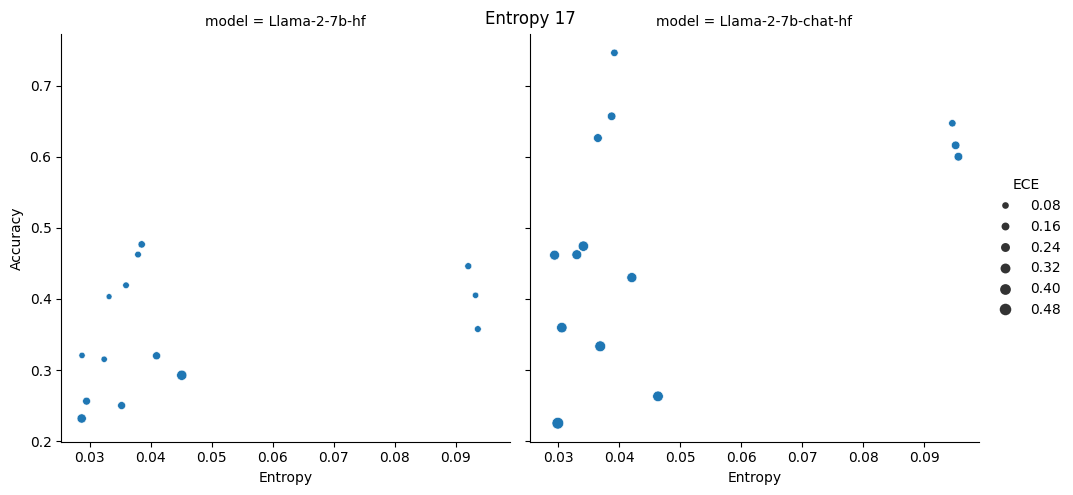

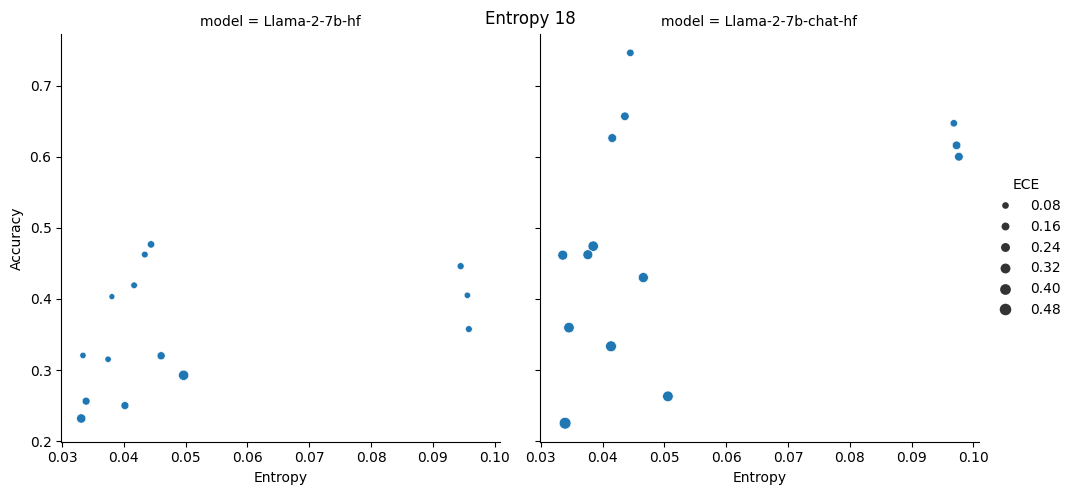

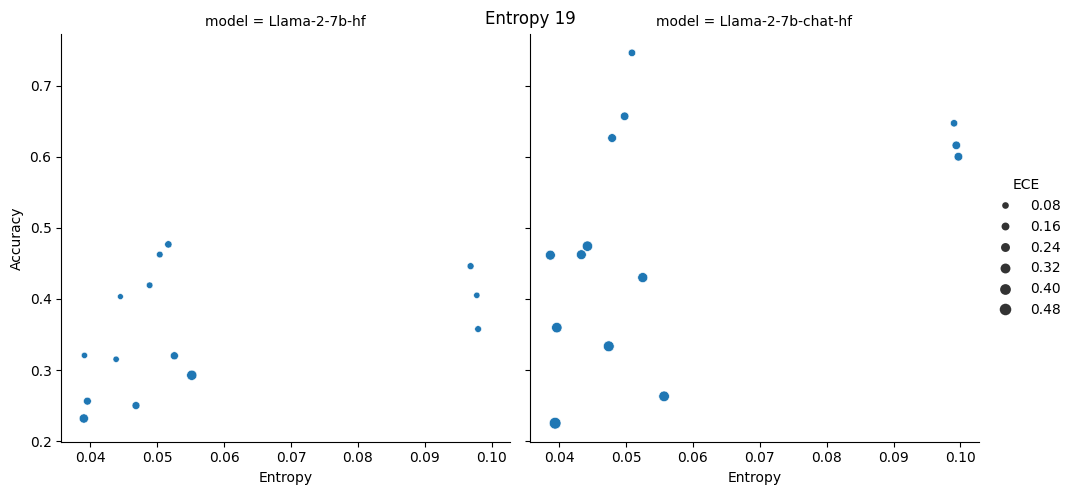

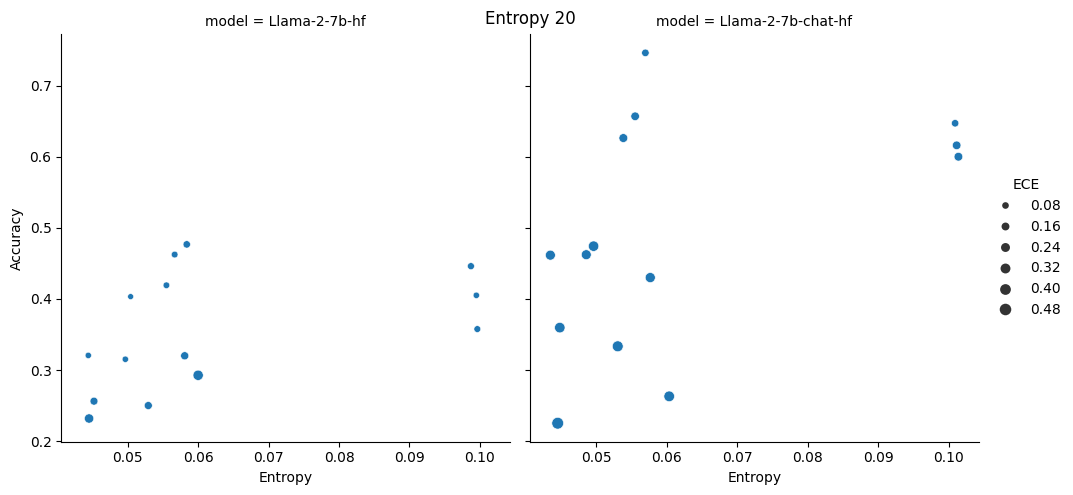

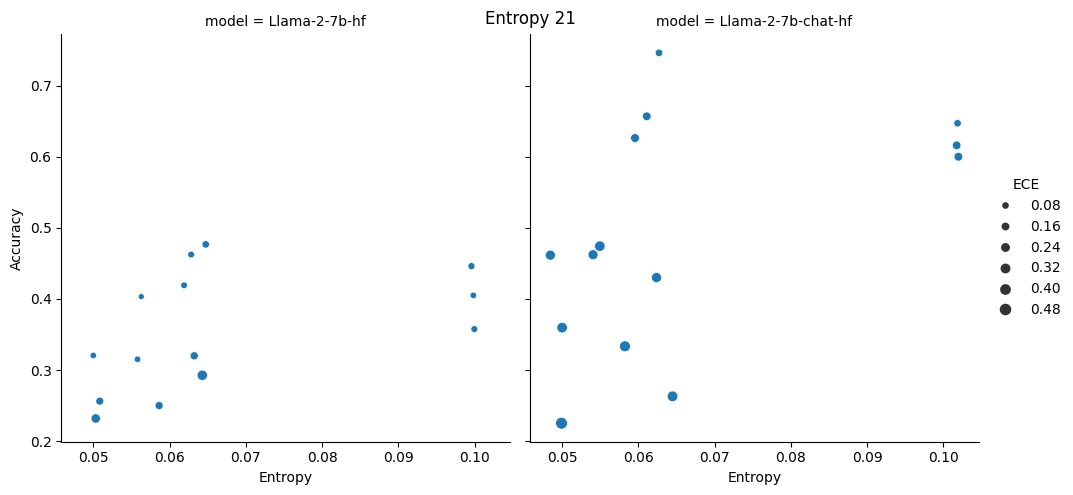

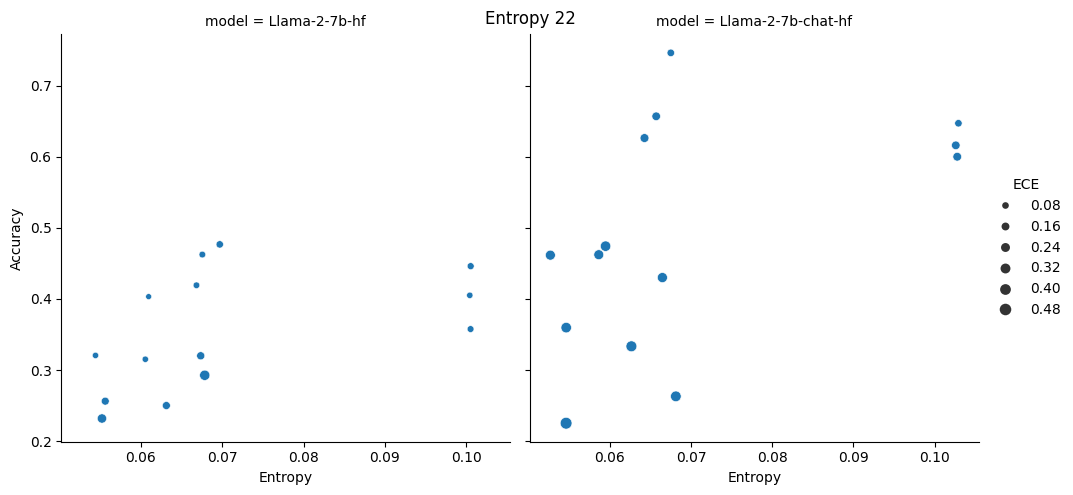

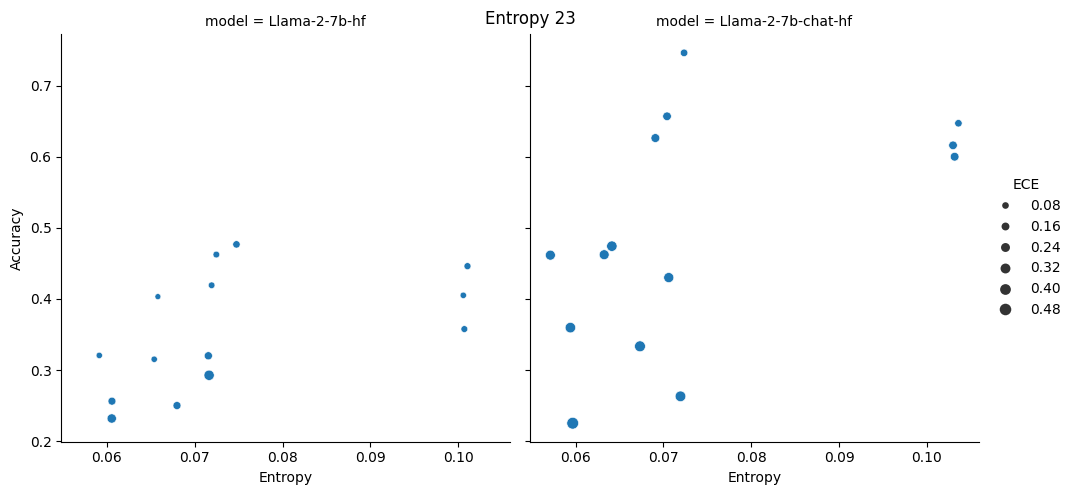

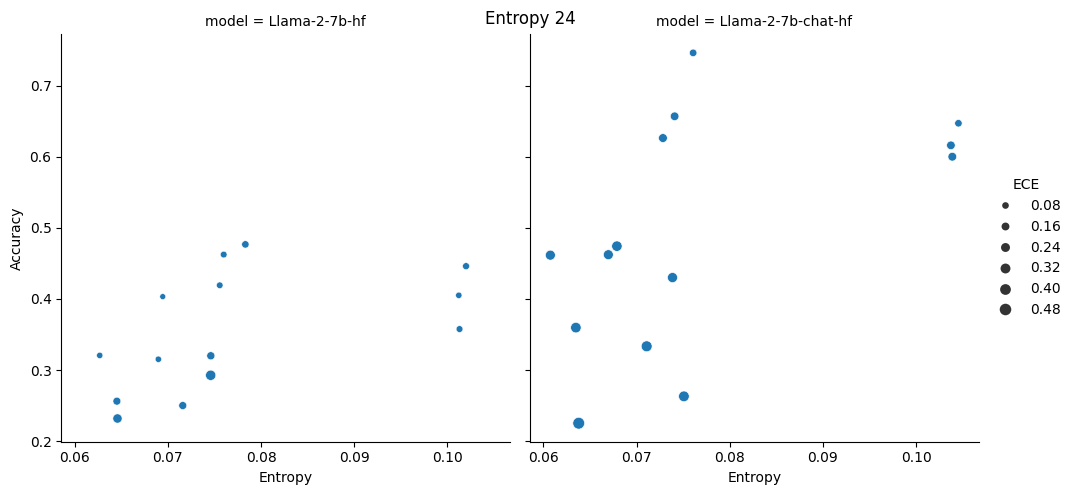

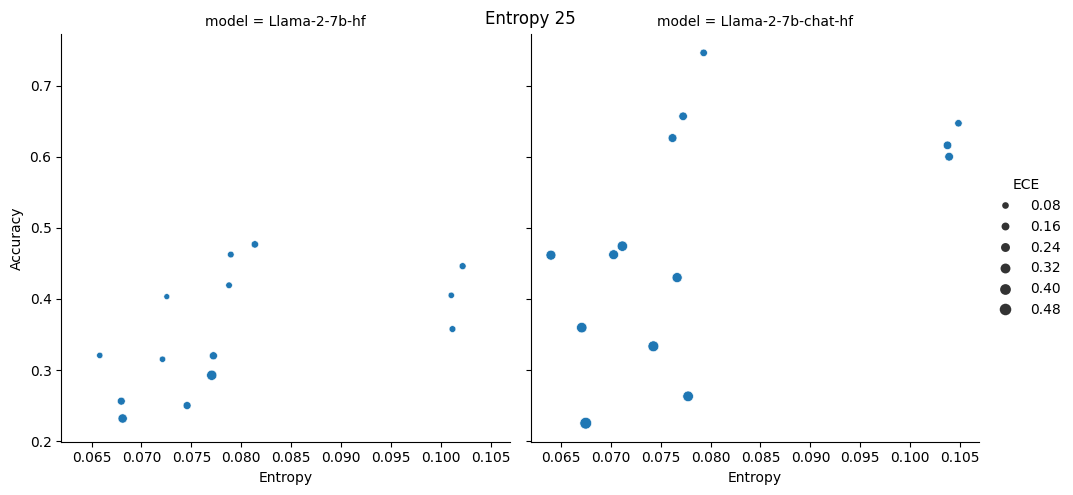

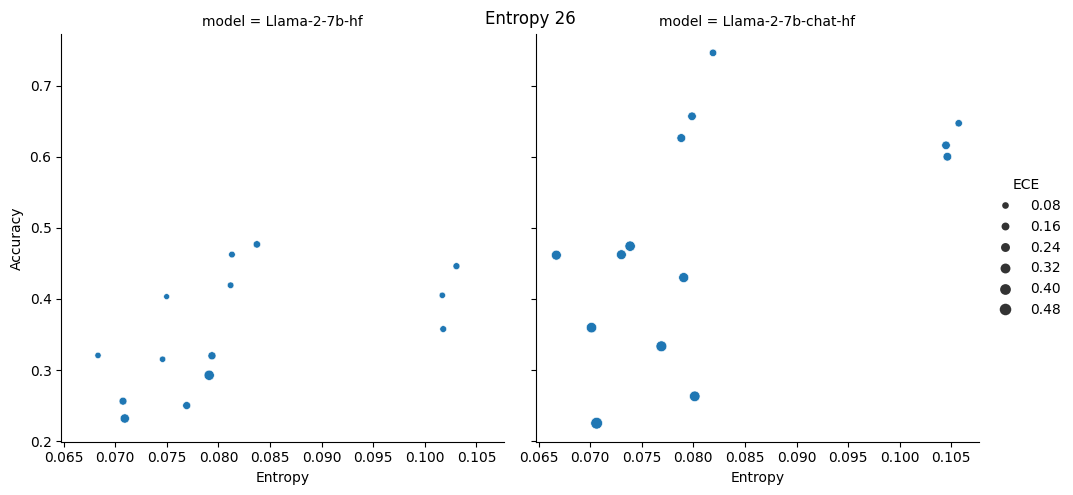

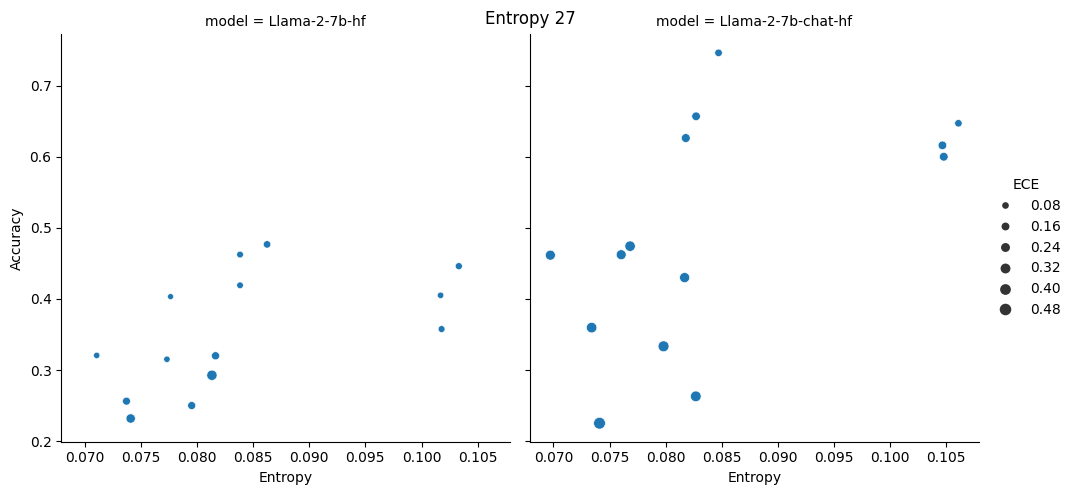

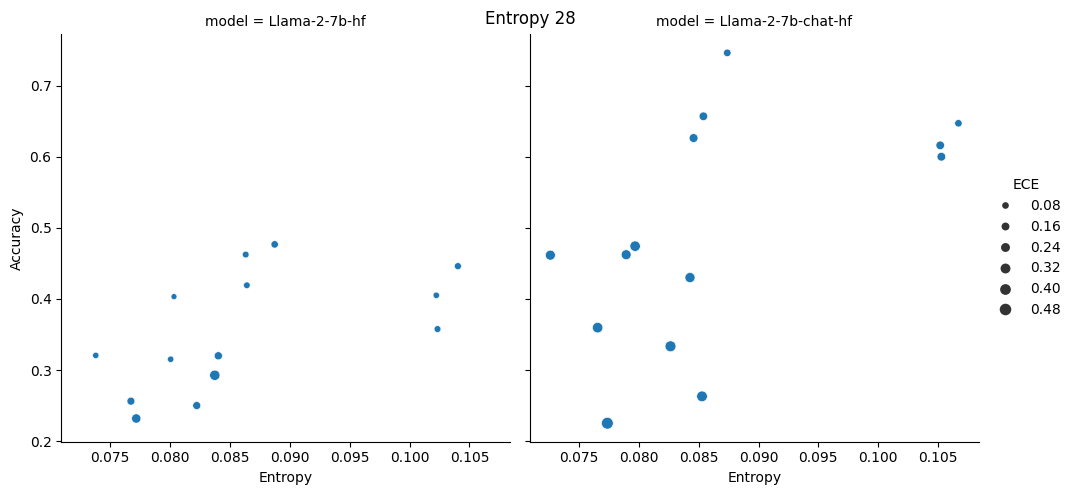

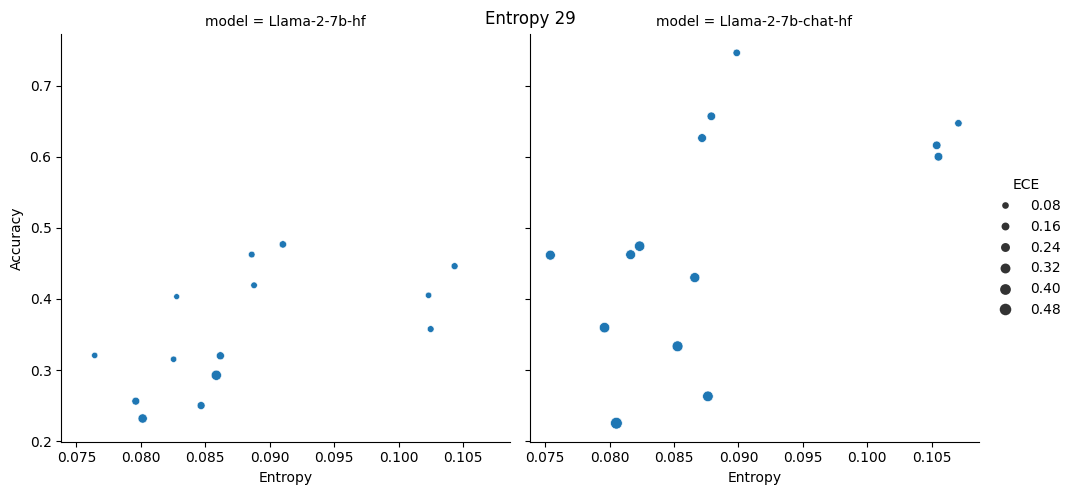

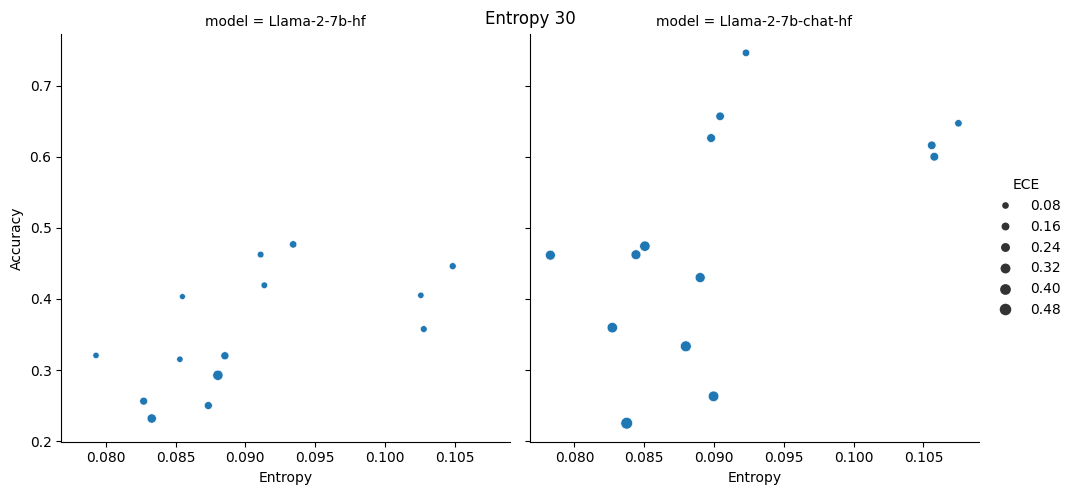

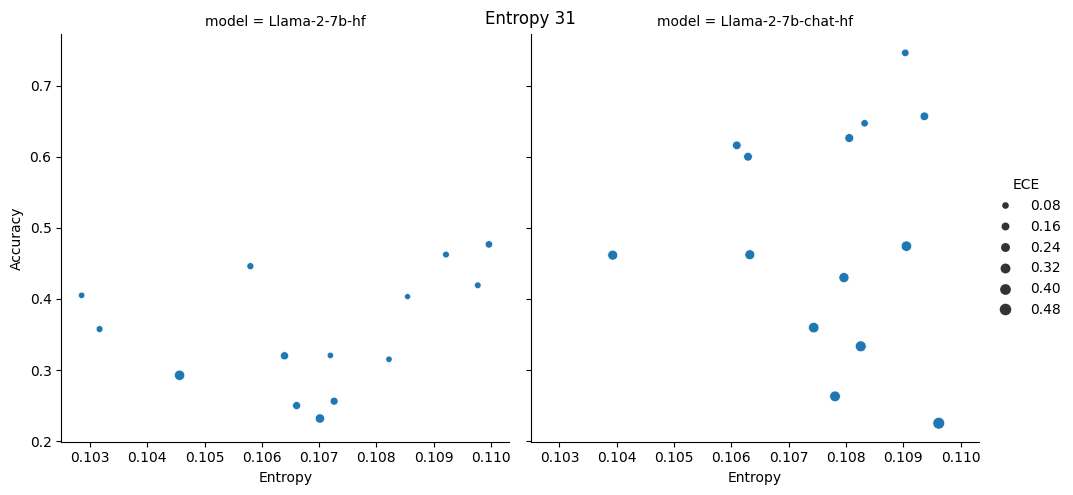

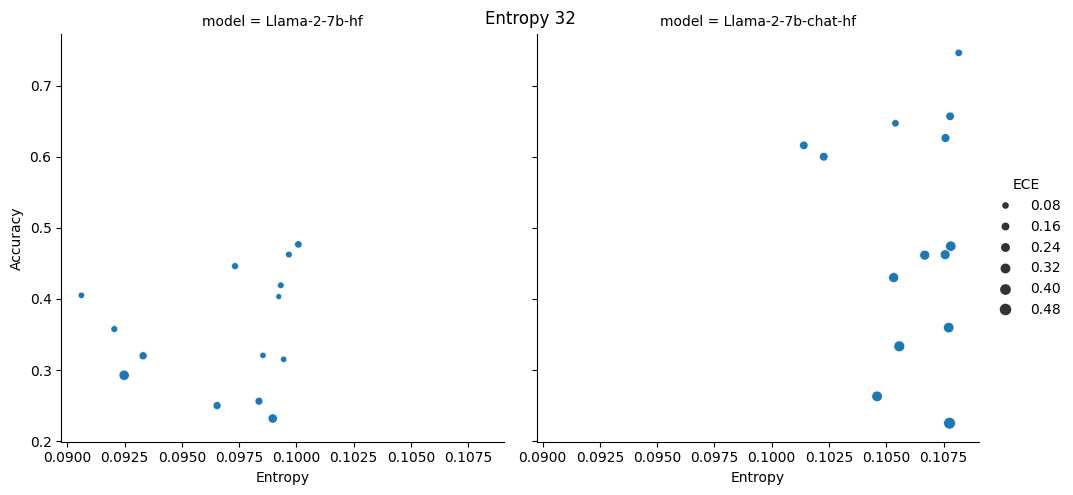

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

entropy = "logNlogD_normalized_entropy"

for i in range(len(df.iloc[0][entropy])):
    ax1 = sns.relplot(
        data=df,
        x=f"{entropy}_{i}",
        y="acc",
        col="model",
        size="ece",
        legend=True
    )
    ax1._legend.set_title('ECE')
    # set shared title for whole plot
    ax1.fig.suptitle(f"Entropy {i}")
    ax1.set(xlabel='Entropy', ylabel='Accuracy')
    plt.show()

In [38]:
entropy = "logNlogD_normalized_entropy"

long_df = df.explode(entropy)
long_df['hidden_state'] = long_df.groupby(['model', 'dataset']).cumcount()
long_df = long_df.rename(columns={entropy: 'entropy'})

min_size = 1
max_size = 5
long_df['size_acc'] = min_size + (long_df['acc'] - long_df['acc'].min()) / (long_df['acc'].max() - long_df['acc'].min()) * (max_size - min_size)
long_df['size_ece'] = min_size + (long_df['ece'] - long_df['ece'].min()) / (long_df['ece'].max() - long_df['ece'].min()) * (max_size - min_size)


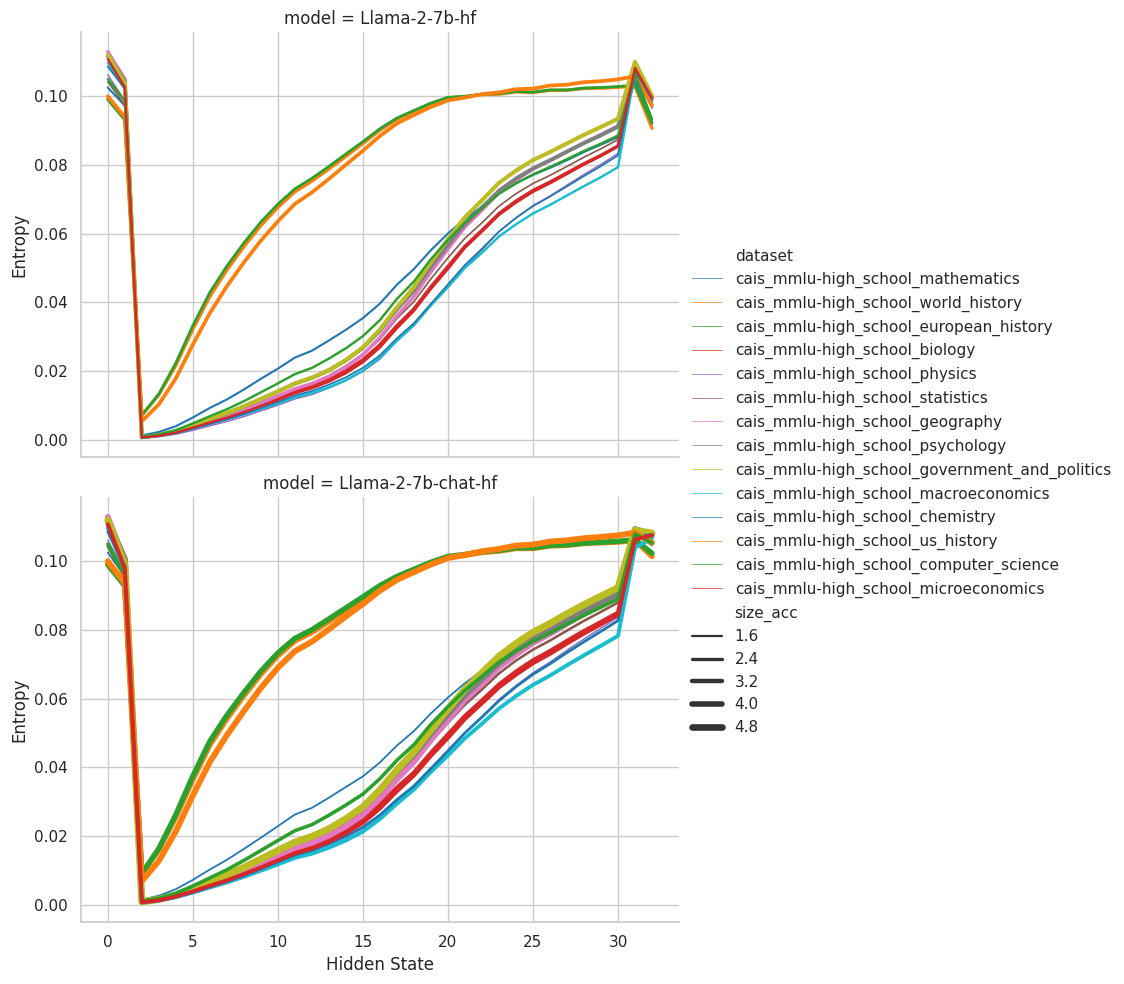

In [40]:
# Plot using Seaborn relplot
sns.set(style="whitegrid")

g = sns.relplot(
    data=long_df,
    x='hidden_state', y='entropy', hue='dataset', size='size_acc',
    kind='line', row='model', facet_kws={'sharey': True, 'sharex': True},
    palette='tab10', sizes=(min_size, max_size), height=5, aspect=1.5, linewidth=0.5,
    markers=True, dashes=False
)

g.set_axis_labels("Hidden State", "Entropy")
g.set_titles(col_template="{col_name} Model")

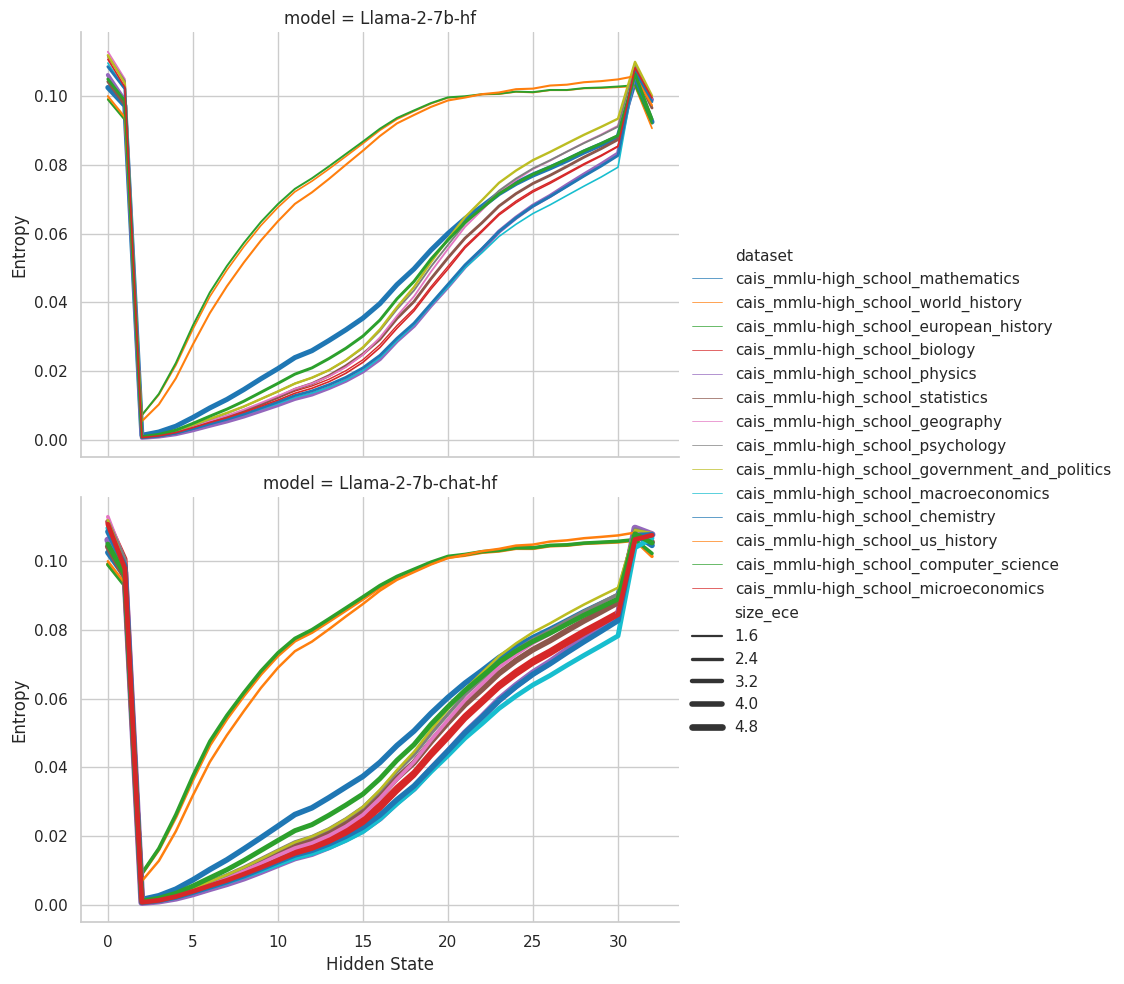

In [41]:
# Plot using Seaborn relplot
sns.set(style="whitegrid")

g = sns.relplot(
    data=long_df,
    x='hidden_state', y='entropy', hue='dataset', size='size_ece',
    kind='line', row='model', facet_kws={'sharey': True, 'sharex': True},
    palette='tab10', sizes=(min_size, max_size), height=5, aspect=1.5, linewidth=0.5
)

g.set_axis_labels("Hidden State", "Entropy")
g.set_titles(col_template="{col_name} Model")